In [1]:
import dask.dataframe as dd
import pandas as pd

In [2]:
from dask.distributed import Client, progress, LocalCluster
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 31.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51072,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 31.85 GiB
Comm: tcp://127.0.0.1:51099,Total threads: 4
Dashboard: http://127.0.0.1:51100/status,Memory: 7.96 GiB
Nanny: tcp://127.0.0.1:51076,


<center>
    <h3>Library</h3>
</center>

In [3]:
# general tools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import re
import datetime as dt
import json
import requests
import scipy as sp
import numpy as np
import tempfile
import random
import time
import math
import statistics
import os
from typing import Tuple, Dict, List
import sys
import warnings
warnings.filterwarnings('ignore')

# preprocessing & utils
import nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# ml models
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier

# others
from wordcloud import WordCloud
from matplotlib.ticker import FormatStrFormatter

<center>
    <h3>Constant</h3>
</center>

In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

<center>
    <h3>Utility Function</h3>
</center>

In [5]:
# processsing
def pipe_cleaningText(text: str) -> str:
    txt = text.lower()
    return txt

def pipe_removeStopWords(text: str, tokenized: bool = False) -> str:
    if tokenized:
        return " ".join([w for w in text.split(" ") if w not in stop_words])
    return " ".join([w for w in word_tokenize(text) if w not in stop_words])

def pipe_lemmatization(text: str, tokenized: bool = False) -> str:
    txt = ""
    collections = word_tokenize(text) if not tokenized else text.split(" ")
    for w in collections:
        txt += lemmatizer.lemmatize(w) + ' '
    return txt.strip()

def pipe_addPos(text: str, tokenized: bool = False) -> str:
    txt = ""
    collections = word_tokenize(text) if not tokenized else text.split(" ")
    for w in pos_tag(collections):
        txt += '__'.join(w) + ' '
    return txt.strip()

def pipe_normalized(text: str, bin: int, tokenized: bool = False) -> str:
    txt = ""
    collections = word_tokenize(text) if not tokenized else text.split(" ")
    n = len(collections)
    for i, w in enumerate(collections):
        normVal = math.floor((i / (n - 1)) * (bin - 1)) + 1 if n != 1 else 1
        txt += w + '__' + str(normVal) + ' '
    return txt.strip()

def pipe_subjectCleaning(text: str, tokenized: bool = False) -> str:
    txt = ""
    collections = sent_tokenize(text) if not tokenized else text.split(" ")
    for s in collections:
        for w in pos_tag(word_tokenize(s)):
            if w[1] != 'NNP':
                continue
            txt += w[0] + ' '
    return txt.strip()

# feature extraction
def feature_tfidfUni(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, TfidfVectorizer]:
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=max_features)
    tfidf_vectorizer.fit(series)
    return tfidf_vectorizer.transform(series), tfidf_vectorizer

def feature_bowUni(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, CountVectorizer]:
    bow_vectorizer = CountVectorizer(ngram_range=(1,1), max_features=max_features)
    bow_vectorizer.fit(series)
    return bow_vectorizer.transform(series), bow_vectorizer

def feature_tfidfUniBi(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, TfidfVectorizer]:
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=max_features)
    tfidf_vectorizer.fit(series)
    return tfidf_vectorizer.transform(series), tfidf_vectorizer

def feature_bowUniBi(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, CountVectorizer]:
    bow_vectorizer = CountVectorizer(ngram_range=(1,2), max_features=max_features)
    bow_vectorizer.fit(series)
    return bow_vectorizer.transform(series), bow_vectorizer

# sampling
def balancing_upsampling(data: pd.DataFrame, target: int=None) -> pd.DataFrame:
    group_res = data.groupby(by=['overall'])['overall'].count()
    highest_n = max(group_res.values) if not target else target
    thedata = data[data.overall == group_res[group_res == highest_n].index[0]] if not target else data.drop(data.index)
    for i in group_res.index:
        if group_res.loc[i] == highest_n:
            continue
        tdata = data[data.overall == i]
        sample_ind = np.random.choice(tdata.index, highest_n - group_res.loc[i], replace=True)
        thedata = pd.concat([thedata, tdata, tdata.loc[sample_ind]])
    return thedata

def balancing_downsampling(data: pd.DataFrame, target: int=None) -> pd.DataFrame:
    group_res = data.groupby(by=['overall'])['overall'].count()
    lowest_n = min(group_res.values) if not target else target
    thedata = data[data.overall == group_res[group_res == lowest_n].index[0]] if not target else data.drop(data.index)
    for i in group_res.index:
        if group_res.loc[i] == lowest_n:
            continue
        tdata = data[data.overall == i]
        sample_ind = np.random.choice(tdata.index, lowest_n, replace=False)
        thedata = pd.concat([thedata, tdata.loc[sample_ind]])
    return thedata

# testing
def accuracyTrainTest(model, trainX: np.array, trainY: np.array, valX: np.array, valY: np.array, testX: np.array, testY: np.array) -> Tuple[float, float, float]:
    mod = model.fit(trainX, trainY)
    yfit = mod.predict(trainX)
    ypredVal = mod.predict(valX)
    ypredTest = mod.predict(testX)
    
    # train result, validation result, test result
    return accuracy_score(trainY, yfit), accuracy_score(valY, ypredVal), accuracy_score(testY, ypredTest)
    
def loop_testing(model, n_test: int, xArr: sp.sparse.csr_matrix, yArr: np.array, testXArr: sp.sparse.csr_matrix, testYArr: np.array) -> Dict[str, List[float]]:
    thedict = {}

    i = 0
    n = xArr.shape[0]
    n_sample = math.ceil(n / n_test)
    x_sam, y_sam = np.array([]), np.array([])
    while i < n_test:
        percent_sample = n_sample/xArr.shape[0]
        if percent_sample >= 1:
            xmain, ymain = xArr, yArr
        else:
            xmain, xArr, ymain, yArr = train_test_split(xArr, yArr, train_size=percent_sample, stratify=yArr, random_state=123)
        
        x_sam = sp.sparse.vstack((x_sam, xmain)) if x_sam.shape[0] != 0 else xmain
        y_sam = np.hstack((y_sam, ymain)) if y_sam.shape[0] != 0 else ymain
        xtrain, xtest, ytrain, ytest = train_test_split(x_sam, y_sam, train_size=0.9, stratify=y_sam, random_state=123)

        resTrain, resVal, resTest = accuracyTrainTest(model, xtrain, ytrain, xtest, ytest, testXArr, testYArr)
        thedict[x_sam.shape[0]] = [resTrain, resVal, resTest]

        i += 1
    return thedict

# visualization
def show_result(ypred: np.array, ytarget: np.array) -> None:
    label = ['Positive', 'Neutral', 'Negative']
    report = classification_report(ypred, ytarget, labels=label)
    conf_matrix = confusion_matrix(ypred, ytarget, labels=label)

    group_names = ['True Pos', 'False Neu', 'False Neg',
                   'False Pos', 'True Neu', 'False Neg',
                   'False Pos', 'False Neu', 'True Neg']
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_percentages, conf_matrix.flatten())]
    labels = np.asarray(labels).reshape(3, 3)

    df_cm = pd.DataFrame(data=conf_matrix, index=label, columns=label)

    print(report)
    fix, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.heatmap(df_cm, xticklabels=label, yticklabels=label, annot=labels, ax=axe, cmap = 'Blues', fmt = '')
    plt.show();

def visualized_loopTesting(result_loopTesting: Dict[str, List[float]]) -> None:
    train_res, val_res, test_res = dict(), dict(), dict()
    for res in result_loopTesting:
        train_res[res] = result[res][0]
        val_res[res] = result[res][1]
        test_res[res] = result[res][2]

    fig, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.lineplot(y=train_res.values(), x=train_res.keys() , ax=axe, label='train-result')
    sns.lineplot(y=val_res.values(), x=val_res.keys(), ax=axe, label='val-result')
    sns.lineplot(y=test_res.values(), x=test_res.keys(), ax=axe, label='test-result')
    axe.set_title("Highest Score: {}".format(max(test_res.values())))
    axe.set_xlabel("Dataset Size")
    axe.set_ylabel("Accuracy")
    axe.set_ylim([0.65, 1.0])
    axe.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    plt.show();

# others
def correlation(x: list, y: list) -> float:
    x = np.array(x)
    y = np.array(y)
    bar_x = x.mean()
    bar_y = y.mean()
    sum_xixbar_yiybar = sum((x - bar_x) * (y - bar_y))
    sum_xixbar2 = sum((x - bar_x) ** 2)
    sum_yiybar2 = sum((y - bar_y) ** 2)

    numer = sum_xixbar_yiybar
    denom = (sum_xixbar2 * sum_yiybar2) ** (1 / 2)

    r = numer / denom if denom != 0 else 0

    return r

def gradient(x: list, y: list) -> float:
    p1 = [x[0], y[0]]
    p2 = [x[2], y[2]]

    numer = p1[1] - p2[1]
    denom = p1[0] - p2[0]

    return numer / denom
    

<center>
    <h3>Exploration</h3>
</center>

In [6]:
df = pd.read_csv('../data/Amazon_Electronics.csv')

In [7]:
df.describe()

,overall,unixReviewTime
count,2.094154e+07,2.094154e+07
mean,4.073490e+00,1.425820e+09
std,1.385862e+00,7.772530e+07
min,1.000000e+00,8.811936e+08
25%,4.000000e+00,1.393891e+09
50%,5.000000e+00,1.440461e+09
75%,5.000000e+00,1.478563e+09
max,5.000000e+00,1.538698e+09


In [8]:
df.isnull().sum()

overall                  0
verified                 0
reviewTime               0
reviewerID               0
asin                     0
style             10476370
reviewerName          2668
reviewText            9670
summary               4896
unixReviewTime           0
vote              18254610
image             20594419
dtype: int64

<AxesSubplot:xlabel='overall'>

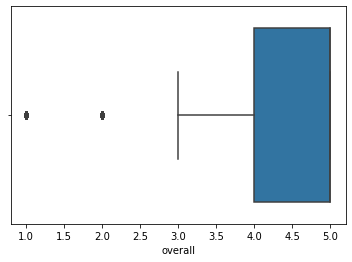

In [9]:
sns.boxplot(df['overall'])

<AxesSubplot:xlabel='overall', ylabel='Count'>

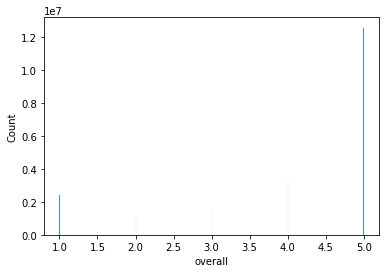

In [10]:
sns.histplot(df['overall'])

In [23]:
dfdata = df[['reviewText', 'overall']]
dfdata.head()

,reviewText,overall
0,This was the first time I read Garcia-Aguilera...,5
1,"As with all of Ms. Garcia-Aguilera's books, I ...",5
2,I've not read any of Ms Aguilera's works befor...,5
3,This romance novel is right up there with the ...,4
4,Carolina Garcia Aguilera has done it again. S...,5


In [24]:
dfdata.isnull().sum()

reviewText    9670
overall          0
dtype: int64

In [26]:
dfdata = dfdata[(~dfdata.isnull().any(axis=1)) & (dfdata.reviewText.apply(lambda x: str(x).strip() != ""))]

In [27]:
dfdata.isnull().sum()

reviewText    0
overall       0
dtype: int64

---

# !IMPORTANT (can modify)

In [28]:
if len(dfdata['overall'].unique()) != 3:
    dfdata['overallOri'] = dfdata['overall']
dfdata['overall'] = dfdata['overallOri'].apply(lambda x: "Positive" if x > 3 else "Negative" if x < 3 else "Neutral")

----

<AxesSubplot:xlabel='overall', ylabel='Count'>

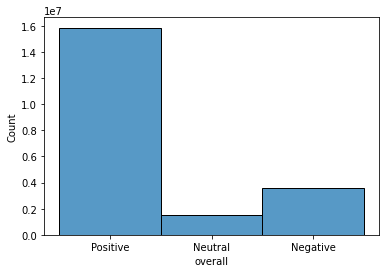

In [29]:
sns.histplot(dfdata['overall'])

In [30]:
target_n = 500 * 1000
dfdataMain, _ = train_test_split(dfdata, train_size=target_n / dfdata.shape[0], stratify=dfdata['overall'], random_state=123)

In [31]:
dfdataMain.shape

(500000, 3)

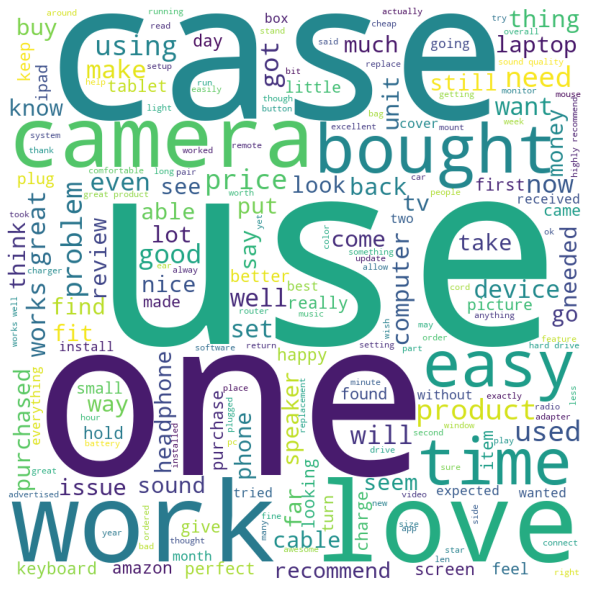

In [32]:
# show wordcloud for the overall text
words = ''
for i, tdf in dfdataMain.iterrows():
    words += ' ' + tdf['reviewText'].lower()

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

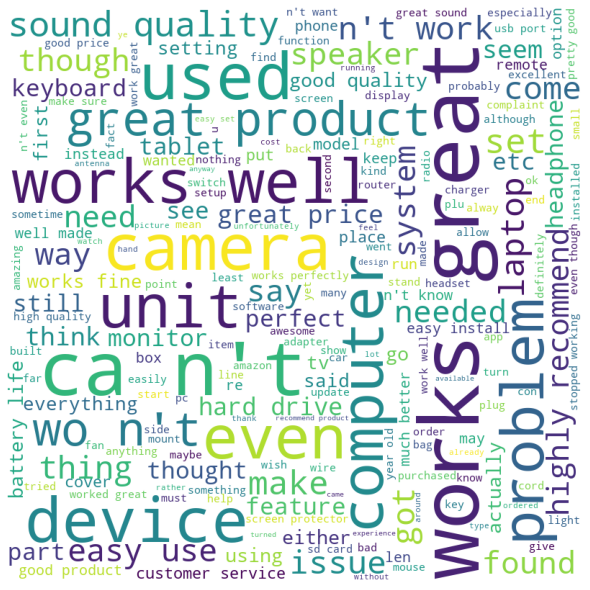

In [33]:
# show wordcloud for the overall text after removing stop words
words = ''
for i, tdf in dfdataMain.iterrows():
    words += ' ' + pipe_removeStopWords(tdf['reviewText'].lower())

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

<center>
    <h3>Process</h3>
</center>

In [34]:
# for training & testing
target_n = 450 * 1000
dfdataTrain, dfdataTest = train_test_split(dfdataMain, train_size=target_n / dfdataMain.shape[0], stratify=dfdataMain['overall'], random_state=123)

In [35]:
# for validation
target_n = 45 * 1000
dfdataValid, dfdataTrainSub = train_test_split(dfdataTrain, train_size=target_n / dfdataTrain.shape[0], stratify=dfdataTrain['overall'], random_state=123)

In [36]:
# for validation training & testing
target_n = 40 * 1000
dfdataValidTrain, dfdataValidTest = train_test_split(dfdataValid, train_size=target_n / dfdataValid.shape[0], stratify=dfdataValid['overall'], random_state=123)

In [37]:
dfdataValidTrain.shape

(40000, 3)

In [38]:
# validation for processing

In [39]:
statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values)

219805850

In [40]:
# upsampling minority group for validation training
if statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values) >= 10 * 1000:
    dfdataValidTrain = balancing_upsampling(dfdataValidTrain)

<AxesSubplot:xlabel='overall', ylabel='Count'>

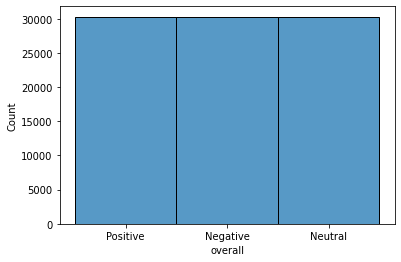

In [41]:
# sample resulf of sampling
sns.histplot(dfdataValidTrain['overall'])

In [42]:
statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values)

0

In [43]:
# base nb model
nb_model = MultinomialNB()

Correlation last 3: 0.1144
Gradient last 3: 0.0003


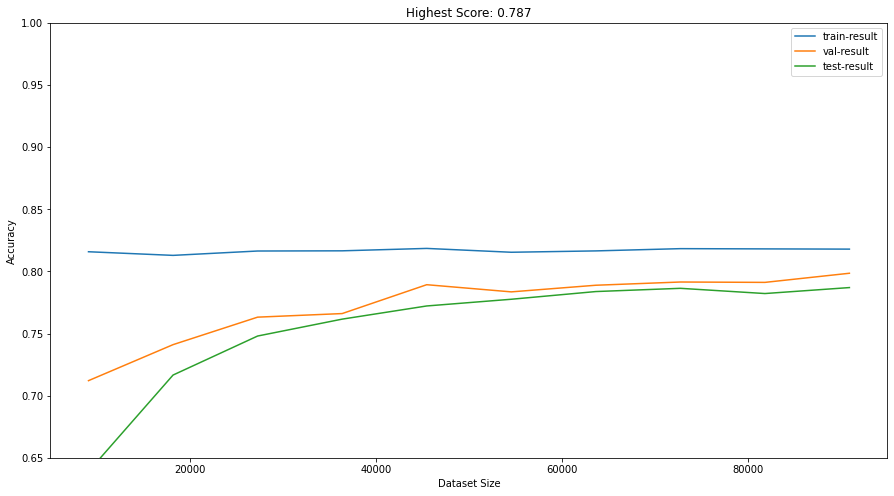

In [44]:
# pipeline 0: no preprocessing

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.1144
Gradient last 3: 0.0003


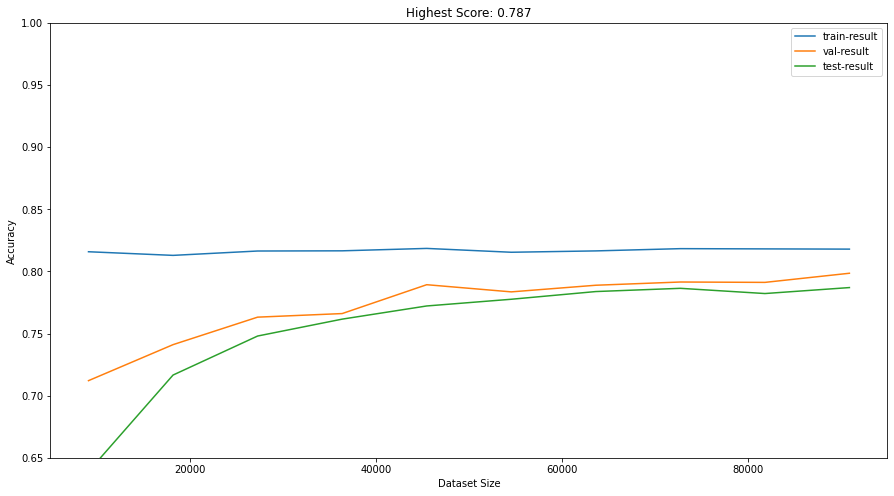

In [45]:
# pipeline 1: cleaningText
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.3271
Gradient last 3: 0.0001


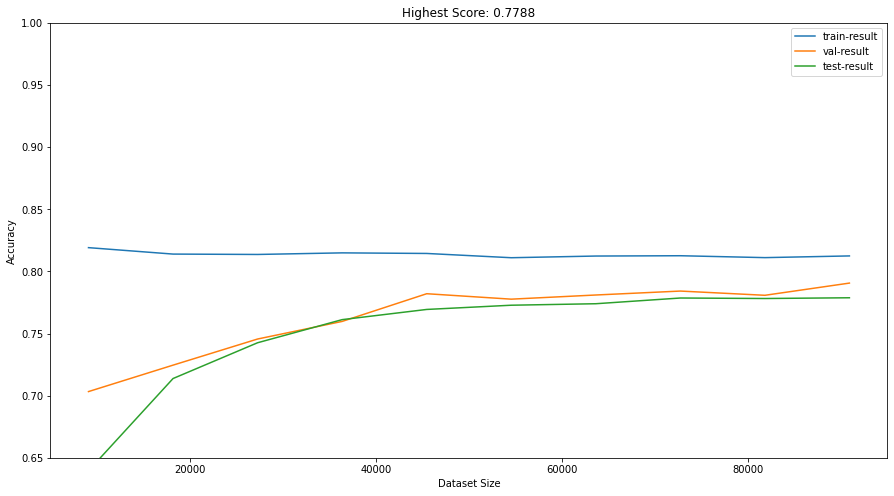

In [46]:
# pipeline 2: cleaningText -> removeStopWords
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_removeStopWords(txt)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.3709
Gradient last 3: 0.0006


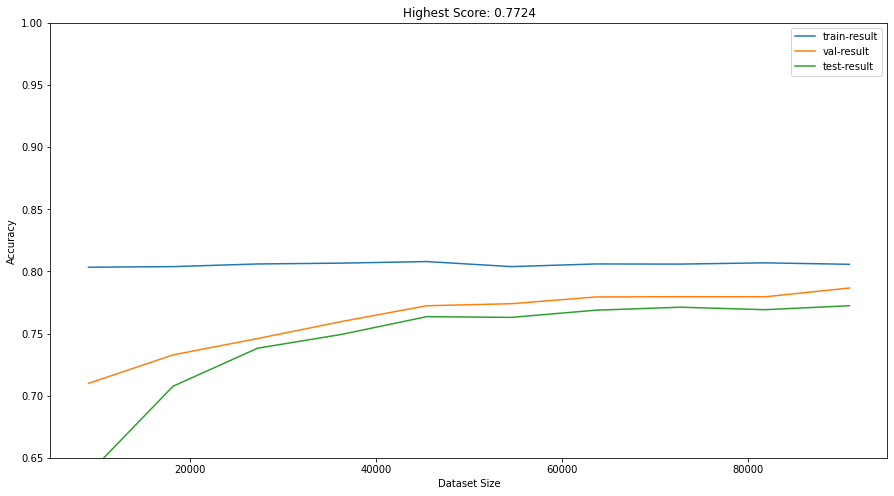

In [47]:
# pipeline 3: cleaningText -> lemmatized
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_lemmatization(txt)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9210
Gradient last 3: 0.0015


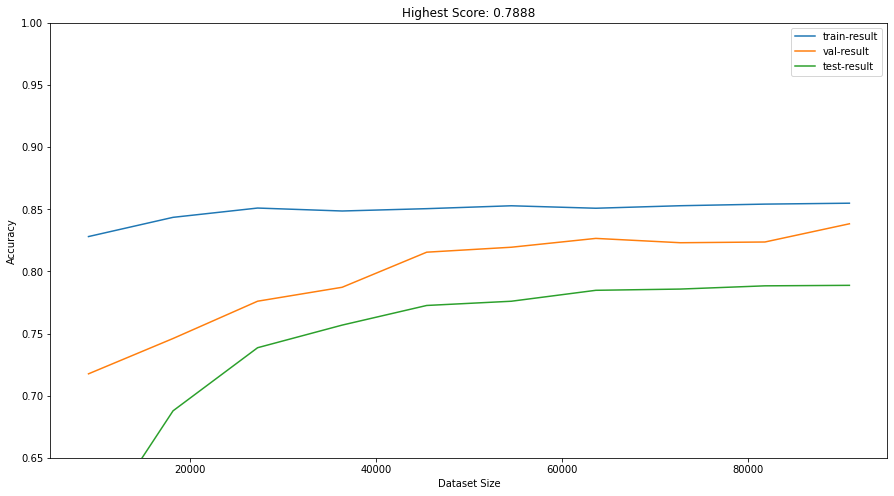

In [48]:
# pipeline 4: cleaningText -> addPos
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_addPos(txt)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9334
Gradient last 3: 0.0006


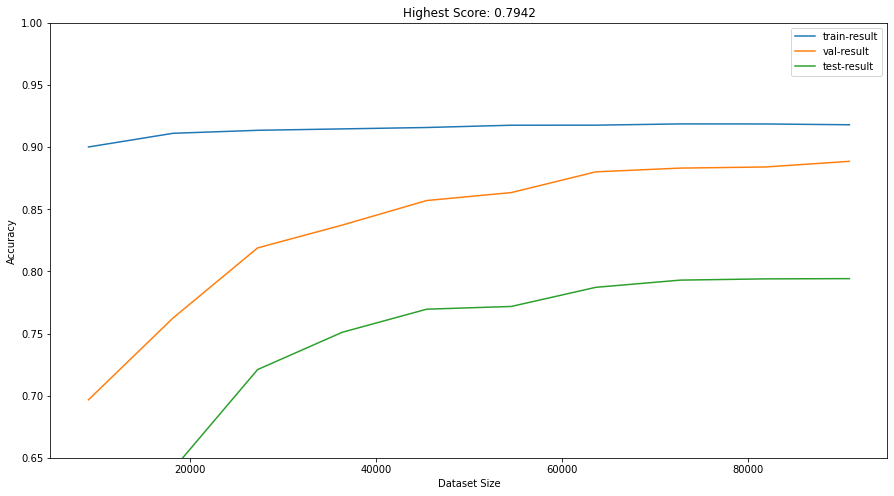

In [49]:
# pipeline 5: cleaningText -> normalized 10 position
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_normalized(txt, 10)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.7135
Gradient last 3: 0.0020


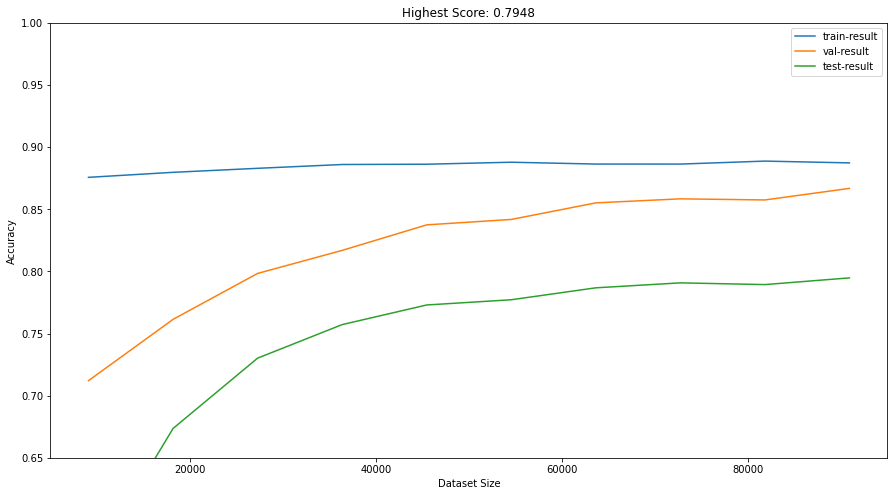

In [50]:
# pipeline 6: cleaningText -> normalized 5 position
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_normalized(txt, 5)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9819
Gradient last 3: 0.0021


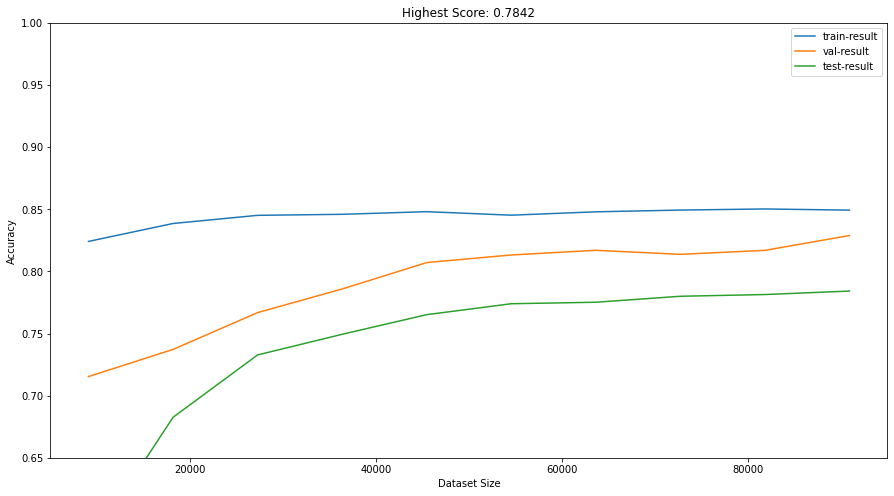

In [51]:
# pipeline 7: cleaningText -> lemmatized -> addPos
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_lemmatization(txt)
    txt = pipe_addPos(txt, tokenized=True)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9521
Gradient last 3: 0.0018


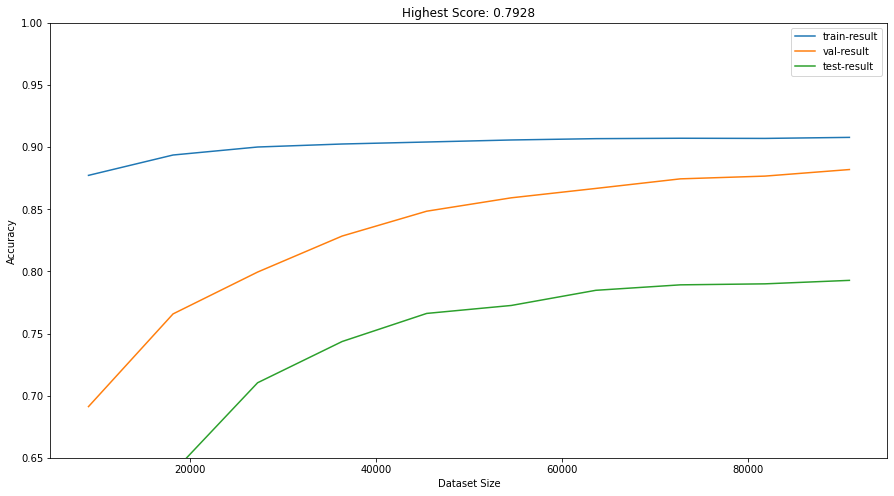

In [52]:
# pipeline 8: cleaningText -> lemmatized -> addPos -> normalized 5 position
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_lemmatization(txt)
    txt = pipe_addPos(txt, tokenized=True)
    txt = pipe_normalized(txt, 5, tokenized=True)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.8924
Gradient last 3: 0.0016


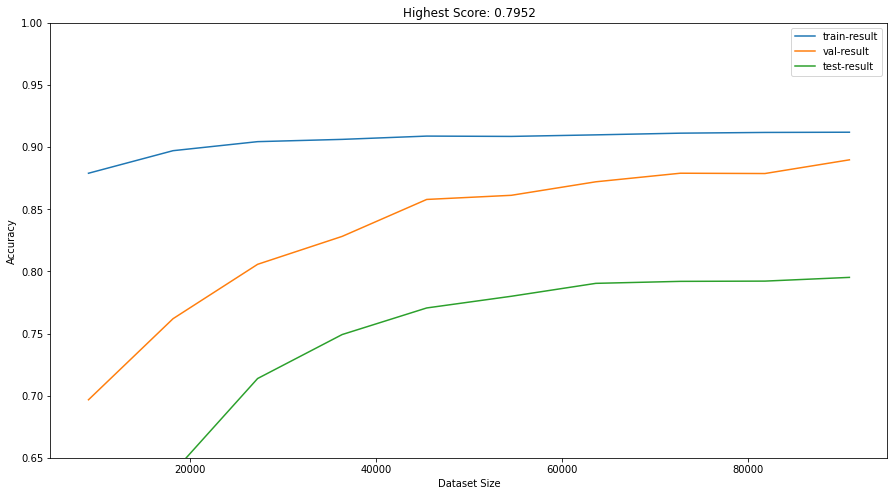

In [53]:
# pipeline 9: cleaningText -> addPos -> normalized 5 position
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_addPos(txt)
    txt = pipe_normalized(txt, 5, tokenized=True)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.6994
Gradient last 3: 0.0026


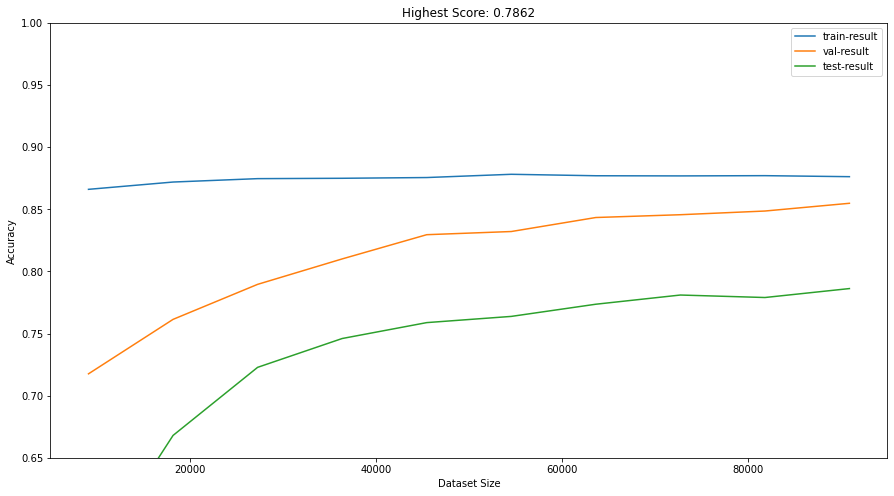

In [54]:
# pipeline 10: cleaningText -> lemmatized -> normalized 5 position
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_lemmatization(txt)
    txt = pipe_normalized(txt, 5, tokenized=True)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

In [55]:
# test on top 3

In [56]:
dfdataValid.shape

(45000, 3)

              precision    recall  f1-score   support

    Positive       0.95      0.89      0.92     36222
     Neutral       0.13      0.32      0.18      1317
    Negative       0.69      0.71      0.70      7461

    accuracy                           0.84     45000
   macro avg       0.59      0.64      0.60     45000
weighted avg       0.88      0.84      0.86     45000



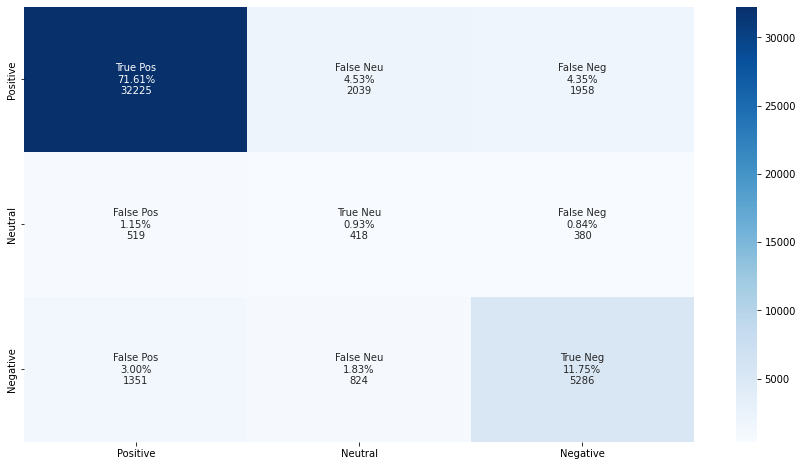

In [57]:
tdf1 = dfdataTrainSub.copy()
tdf2 = dfdataValid.copy()
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
nb_model.fit(xArr, yArr)
yHat = nb_model.predict(testXArr)
show_result(yHat, testYArr)

              precision    recall  f1-score   support

    Positive       0.97      0.88      0.92     37731
     Neutral       0.03      0.41      0.06       247
    Negative       0.69      0.75      0.72      7022

    accuracy                           0.85     45000
   macro avg       0.56      0.68      0.56     45000
weighted avg       0.92      0.85      0.88     45000



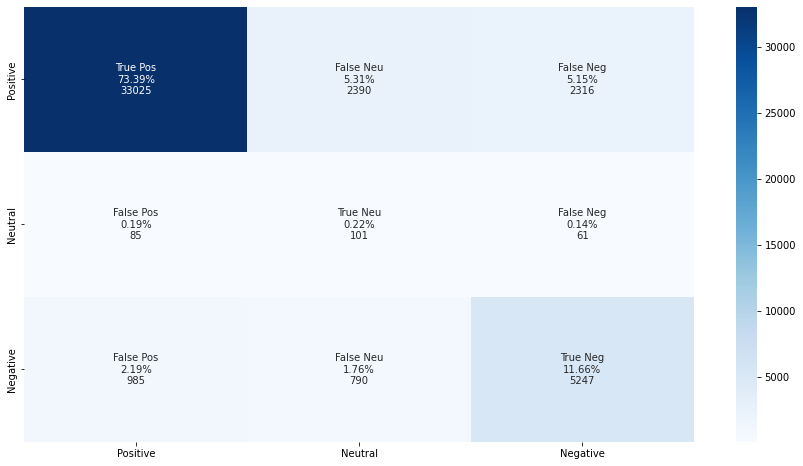

In [58]:
# option 1: cleaningText -> addPos -> Normalized
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_addPos(txt)
    txt = pipe_normalized(txt, 5, tokenized=True)
    return txt

tdf1 = dfdataTrainSub.copy()
tdf2 = dfdataValid.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
nb_model.fit(xArr, yArr)
yHat = nb_model.predict(testXArr)
show_result(yHat, testYArr)

              precision    recall  f1-score   support

    Positive       0.97      0.87      0.92     37811
     Neutral       0.03      0.43      0.06       238
    Negative       0.68      0.75      0.71      6951

    accuracy                           0.85     45000
   macro avg       0.56      0.68      0.56     45000
weighted avg       0.92      0.85      0.88     45000



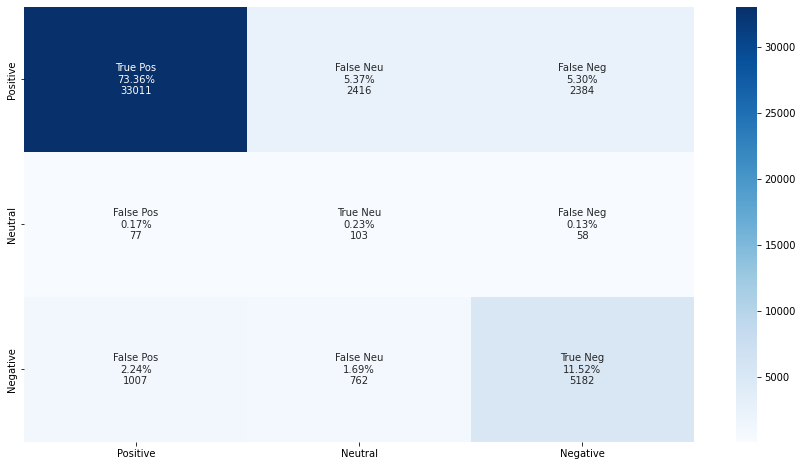

In [59]:
# option 2: cleaningText -> lemmatized -> addPos -> normalized
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_lemmatization(txt)
    txt = pipe_addPos(txt, tokenized=True)
    txt = pipe_normalized(txt, 5, tokenized=True)
    return txt

tdf1 = dfdataTrainSub.copy()
tdf2 = dfdataValid.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
nb_model.fit(xArr, yArr)
yHat = nb_model.predict(testXArr)
show_result(yHat, testYArr)

              precision    recall  f1-score   support

    Positive       0.97      0.87      0.92     37808
     Neutral       0.03      0.38      0.06       264
    Negative       0.68      0.75      0.71      6928

    accuracy                           0.85     45000
   macro avg       0.56      0.67      0.56     45000
weighted avg       0.92      0.85      0.88     45000



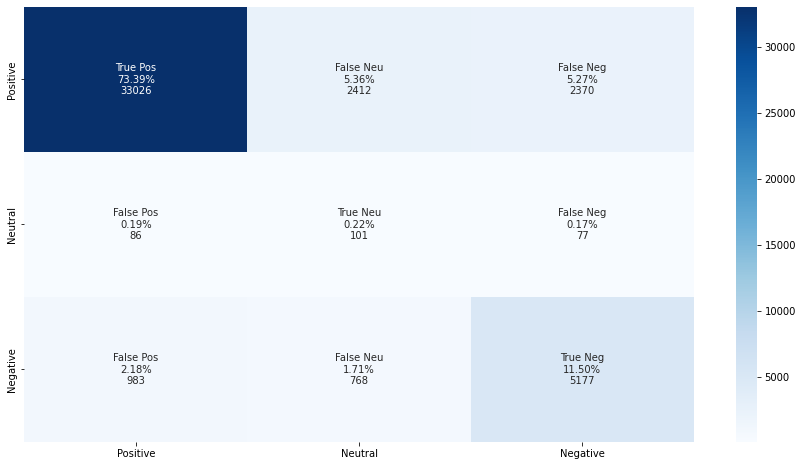

In [60]:
# option 3: cleaningText -> normalized
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_normalized(txt, 10)
    return txt

tdf1 = dfdataTrainSub.copy()
tdf2 = dfdataValid.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
nb_model.fit(xArr, yArr)
yHat = nb_model.predict(testXArr)
show_result(yHat, testYArr)

In [ ]:
df = dd.from_pandas(pd.read_csv('../data/Amazon_Electronics.csv'), npartitions=8)
df = client.persist(df) # persist to keep data in memory when processing
